# 비트코인 시계열 예측

과거의 데이터로부터 미래의 데이터를 예측하는 것은 AI의 중요한 미션 중 하나이다.

대표적으로 주가, 암호화폐 등을 예측하는 시도는 빈번하게 일어나며, 이 중 비트코인의 가격을 예측하는 모델을 수립해보고자 한다.

In [1]:
import ccxt

from datetime import datetime, timedelta
import time
import pytz

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import mplfinance as mpf

import numpy as np
import pandas as pd

먼저 ccxt 라이브러리를 활용하여 해외 암호화폐 거래소인 바이낸스에서 제공하는 비트코인 선물 시장의 가격 데이터를 불러온다.

In [2]:
# 바이낸스 계정
account = ccxt.binance({
    'apiKey': 'wyF49iyFYiDNiClfGNqBG48DMrHuByyDSIJTQKKw8Z1jRFQtO6EdG3Fk0WNyhaLu',
    'secret': 'PsM244DZAcUTaIHZBYlG4eLJ12dU8Ogt8ckiM2yYRlVSiQyFV1QNaf8N9GO3xUrL',
    'enableRateLimit': True, # 이 옵션을 True로 설정하면, Rate Limit를 준수하게 됩니다.
    'options': { 'defaultType': 'future' }  # 선물 거래를 위해 future를 설정
})

데이터를 받아오는 시간 간격은 1시간이며, 가장 최근 시간으로부터 일년전의 데이터를 받아와 데이터프레임으로 가공한다.

In [3]:
# 타임프레임 지정 (1일)
timeframe = '1h'

# 시장 선택 (비트코인-USDT 선물)
symbol = 'BTC/USDT'

# 데이터 저장을 위한 빈 리스트 생성
data = []

# 현재 시간 캡쳐 (한국 시간으로 설정)
now_date = datetime.now(pytz.timezone('UTC')) # UTC 시간으로 설정
now = now_date.timestamp() * 1000  # milliseconds

# 일 년 전의 타임스탬프를 얻음
since_date = now_date - timedelta(days=365)  # 일 년 전 (UTC 시간)
since = since_date.timestamp() * 1000  # milliseconds

while True:
    try:
        # 1000개의 데이터를 가져옴
        ohlcv = account.fetch_ohlcv(symbol, timeframe, int(since), limit=1000)

        # rate limit를 준수하기 위해 잠시 대기
        time.sleep(account.rateLimit / 1000)  # you may want to add 1-2 seconds of safety margin to avoid a ban

        if len(ohlcv) == 0:  # 더 이상 데이터가 없으면 중지
            break

        # 데이터를 저장함
        data += ohlcv
        
        # 가장 최신 데이터의 시간이 현재 시간을 넘어서면 break
        if data[-1][0] > now:
            break
            
        # 가장 오래된 데이터의 시간을 가져옴
        since = data[-1][0] + 1
        
    except ccxt.NetworkError as e:
        print(account.id, 'fetch_ohlcv failed due to a network error:', str(e))
        time.sleep(account.rateLimit / 1000)  # retry on next iteration after a short delay
    except ccxt.ExchangeError as e:
        print(account.id, 'fetch_ohlcv failed due to exchange error:', str(e))
        time.sleep(account.rateLimit / 1000)  # retry on next iteration after a short delay
    except Exception as e:
        print(account.id, 'fetch_ohlcv failed with:', str(e))
        time.sleep(account.rateLimit / 1000)  # retry on next iteration after a short delay

# 데이터를 pandas dataframe으로 변환
df = pd.DataFrame(data, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])

# timestamp를 읽기 쉬운 datetime 형태로 변환
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

# Set 'datetime' as index
df.set_index('datetime', inplace=True)

print(df)

                        open     high      low    close     volume
datetime                                                          
2022-06-16 07:00:00  21788.4  21928.7  21635.3  21748.9  30695.770
2022-06-16 08:00:00  21748.9  21883.7  21593.0  21773.8  28647.397
2022-06-16 09:00:00  21773.8  21784.8  21122.0  21266.5  62550.902
2022-06-16 10:00:00  21266.5  21367.0  20852.0  21232.9  57283.936
2022-06-16 11:00:00  21232.2  21280.3  20870.0  21028.1  47400.976
...                      ...      ...      ...      ...        ...
2023-06-16 02:00:00  25503.1  25545.0  25470.3  25538.3   6871.944
2023-06-16 03:00:00  25538.3  25596.0  25515.7  25545.7   7549.247
2023-06-16 04:00:00  25545.7  25620.0  25508.8  25515.0  10712.640
2023-06-16 05:00:00  25515.0  25566.4  25461.0  25541.2  11719.507
2023-06-16 06:00:00  25541.2  25616.0  25523.3  25568.4   9134.375

[8760 rows x 5 columns]


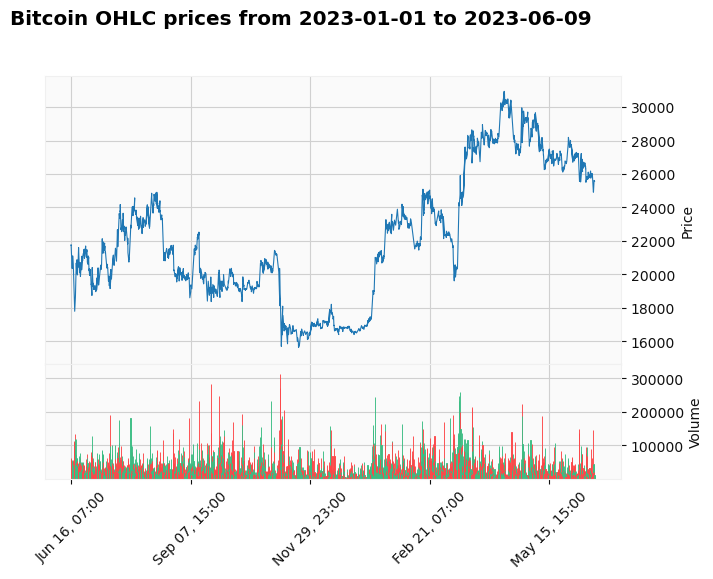

In [4]:
# Create OHLCV chart using mplfinance
mpf.plot(df, type='line', style='yahoo', volume=True, title='Bitcoin OHLC prices from 2023-01-01 to 2023-06-09')

가격 데이터에는 'open', 'high', 'low', 'close', 'volume' 총 다섯 가지의 데이터가 존재하며, 이 데이터를 기반으로 이동평균선, RSI 등의 보조지표를 계산하게 된다.

In [5]:
import talib

"""
각종 보조지표들에 대한 설명은 아래와 같다:

SMA: 일정 기간 동안의 가격 평균. Pandas의 rolling().mean() 함수로 계산할 수 있습니다.
EMA: 최근 가격에 더 많은 가중치를 부여하는 평균. Pandas의 ewm().mean() 함수로 계산할 수 있습니다.
Bollinger Bands: 볼린저 밴드는 SMA 위아래에 2개의 표준 편차를 더한 선을 그립니다. rolling().std() 함수를 사용하여 표준 편차를 계산할 수 있습니다.
Relative Strength Index, RSI: RSI는 가격 변동의 속도와 변동성을 측정하는 모멘텀 오실레이터입니다. talib 라이브러리의 RSI() 함수로 계산할 수 있습니다.
MACD (Moving Average Convergence Divergence): MACD는 두 개의 이동평균선 (EMA) 사이의 차이를 보여줍니다. 그리고 이 차이를 추적하는 또 다른 EMA가 함께 제공됩니다. 이러한 지표는 트렌드의 강도와 방향, 그리고 트렌드의 가능한 반전을 식별하는 데 도움이 됩니다.
Stochastic Oscillator: 이 오실레이터는 가격이 주어진 기간 동안의 범위 내에서 어디에 위치하는지 측정합니다. 이는 과매수 또는 과매도 조건을 식별하는 데 도움이 됩니다.
Volume Weighted Average Price (VWAP): VWAP는 거래량을 고려한 가격의 평균을 제공합니다. 이 지표는 트레이더들이 시장 가격보다 더 좋은 가격으로 거래할 기회를 찾는 데 도움이 됩니다.
Average True Range (ATR): ATR은 주어진 기간 동안 가격 변동성을 측정합니다. 이는 스톱 로스 레벨을 설정하거나 변동성 기반 거래 전략을 구축하는 데 도움이 됩니다.
Chaikin Money Flow (CMF): CMF는 가격과 거래량을 기반으로 한 지표로서, 돈이 시장에 들어오고 나가는 정도를 측정합니다.
On Balance Volume (OBV): OBV는 가격 변동에 대한 거래량의 누적 합계를 측정합니다. 이는 거래량이 가격 변동을 추적하는지 또는 이를 선행하는지를 식별하는 데 도움이 됩니다.
"""

# 이동평균선 계산
df['SMA'] = df['close'].rolling(window=14).mean()
df['EMA'] = df['close'].ewm(span=14, adjust=False).mean()

# 볼린저 밴드 계산
df['std_dev'] = df['close'].rolling(window=20).std()
df['lower_band'] = df['SMA'] - (2 * df['std_dev'])
df['upper_band'] = df['SMA'] + (2 * df['std_dev'])

# RSI 계산
df['RSI'] = talib.RSI(df['close'].values, timeperiod=14)

# Calculate MACD
macd, signal, hist = talib.MACD(df['close'])

df['MACD'] = macd
df['MACD_signal'] = signal
df['MACD_hist'] = hist

# Calculate Stochastic Oscillator
slowk, slowd = talib.STOCH(df['high'], df['low'], df['close'])
df['slowk'] = slowk
df['slowd'] = slowd

# Calculate VWAP
df['VWAP'] = talib.SUM(df['close'] * df['volume'], timeperiod=14) / talib.SUM(df['volume'], timeperiod=14)

# Calculate ATR
df['ATR'] = talib.ATR(df['high'], df['low'], df['close'])

# Calculate Chaikin Money Flow
clv = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
df['CMF'] = talib.SUM(clv * df['volume'], timeperiod=20) / talib.SUM(df['volume'], timeperiod=20)

# Calculate On Balance Volume
df['OBV'] = talib.OBV(df['close'], df['volume'])

# 불필요 칼럼 제거
df = df.drop(['open', 'high', 'low'], axis=1)

# 결측치 제거
df = df.dropna()
df

,close,volume,SMA,EMA,std_dev,lower_band,upper_band,RSI,MACD,MACD_signal,MACD_hist,slowk,slowd,VWAP,ATR,CMF,OBV
datetime,,,,,,,,,,,,,,,,,
2022-06-17 16:00:00,20564.8,29152.472,20781.128571,20756.051441,251.935664,20277.257243,21284.999900,40.561898,-138.468923,-162.742327,24.273405,27.056127,25.770713,20792.279829,374.606971,-0.109558,-250403.670
2022-06-17 17:00:00,20582.9,22621.696,20796.407143,20732.964582,253.395076,20289.616990,21303.197296,41.066733,-137.724645,-157.738791,20.014146,33.571952,29.971070,20804.056725,362.770759,-0.097085,-227781.974
2022-06-17 18:00:00,20512.6,16974.193,20795.942857,20703.582638,244.428075,20307.086708,21284.799006,39.657852,-141.179987,-154.427030,13.247043,33.186694,31.271591,20807.976585,350.522847,-0.072369,-244756.167
2022-06-17 19:00:00,20506.6,15159.841,20775.428571,20677.318286,237.494012,20300.440547,21250.416596,39.533192,-142.756908,-152.093006,9.336098,30.802281,32.520309,20799.758675,333.342644,-0.084359,-259916.008
2022-06-17 20:00:00,20641.0,16618.612,20758.250000,20672.475848,222.622018,20313.005963,21203.494037,43.795102,-131.644160,-148.003237,16.359076,37.698790,33.895922,20787.544086,324.961026,-0.059616,-243297.396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 02:00:00,25538.3,6871.944,25342.178571,25394.637114,279.146272,24783.886028,25900.471115,59.994174,65.339592,1.679585,63.660007,42.958127,52.850782,25380.158705,162.005535,0.231985,-1027884.454
2023-06-16 03:00:00,25545.7,7549.247,25377.942857,25414.778832,281.266207,24815.410443,25940.475271,60.311476,70.735059,15.490680,55.244379,46.336582,45.988187,25415.552588,156.169425,0.201365,-1020335.207
2023-06-16 04:00:00,25515.0,10712.640,25414.414286,25428.141654,277.907552,24858.599182,25970.229389,58.247440,71.707177,26.733979,44.973197,53.784885,47.693198,25438.130066,152.957324,0.199931,-1031047.847


모델에서는 'close' 칼럼을 target으로 하여 예측을 진행할 예정으로 불필요한 데이터를 삭제하고 보조지표들을 추가하였다.

In [6]:
"""
normalization된 데이터 중 'close' 칼럼만 추후 복원될 예정이므로 해당 칼럼의 scaler를 따로 선언해준다.
"""

# 1. Data normalization
# Separate scaler for 'close'
scaler_close = MinMaxScaler()
df[['close']] = scaler_close.fit_transform(df[['close']])

# Create a MinMaxScaler for each column
scalers = {}
for i in df.columns:
    scaler = MinMaxScaler()
    s_s = scaler.fit_transform(df[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    df[i]=s_s
    scalers['scaler_'+ i] = scaler
    
df

,close,volume,SMA,EMA,std_dev,lower_band,upper_band,RSI,MACD,MACD_signal,MACD_hist,slowk,slowd,VWAP,ATR,CMF,OBV
datetime,,,,,,,,,,,,,,,,,
2022-06-17 16:00:00,0.321996,0.089070,0.334862,0.333681,0.252803,0.347448,0.349851,0.380127,0.401077,0.370423,0.540528,0.246681,0.236753,0.336558,0.693936,0.428236,0.850114
2022-06-17 17:00:00,0.323179,0.068072,0.335883,0.332130,0.254309,0.348251,0.351049,0.386232,0.401560,0.374030,0.530828,0.316379,0.283779,0.337344,0.670833,0.442051,0.855254
2022-06-17 18:00:00,0.318585,0.049913,0.335852,0.330156,0.245053,0.349387,0.349838,0.369195,0.399319,0.376417,0.515418,0.312258,0.298339,0.337605,0.646926,0.469426,0.851397
2022-06-17 19:00:00,0.318193,0.044080,0.334481,0.328392,0.237896,0.348955,0.347575,0.367688,0.398297,0.378099,0.506511,0.286753,0.312319,0.337057,0.613392,0.456146,0.847952
2022-06-17 20:00:00,0.326976,0.048770,0.333333,0.328067,0.222544,0.349772,0.344486,0.419226,0.405502,0.381047,0.522505,0.360523,0.327720,0.336243,0.597032,0.483551,0.851728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 02:00:00,0.647038,0.017431,0.639576,0.645266,0.280890,0.640526,0.653638,0.615117,0.533213,0.488932,0.630224,0.416781,0.539934,0.642469,0.278958,0.806528,0.673460
2023-06-16 03:00:00,0.647522,0.019609,0.641965,0.646619,0.283078,0.642576,0.656272,0.618954,0.536711,0.498886,0.611059,0.452920,0.463102,0.644829,0.267566,0.772614,0.675175
2023-06-16 04:00:00,0.645516,0.029780,0.644402,0.647517,0.279612,0.645385,0.658230,0.593994,0.537341,0.506990,0.587668,0.532592,0.482191,0.646334,0.261296,0.771026,0.672741


In [19]:
class ForecastLSTM:
    def __init__(self, random_seed: int = 1234):
        self.random_seed = random_seed
    
    # 데이터의 shape을 변경
    def reshape_dataset(self, target: str, df: pd.DataFrame) -> np.array:
        # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
        if target in df.columns:
            df = df.drop(columns=[target]).assign(y=df[target])
        else:
            raise KeyError("Not found target column {} in dataset.".format(target))

        # shape 변경
        dataset = df.values.reshape(df.shape)
        return dataset
    
    """
    변환된 데이터셋을 Sequence Length와 step에 따라 Sequence Data로 변환하는 함수
    """
    def split_sequences(
        self, dataset: np.array, seq_len: int, steps: int, single_output: bool
    ) -> tuple:

        # feature와 y 각각 sequential dataset을 반환할 리스트 생성
        X, y = list(), list()
        # sequence length와 step에 따라 sequential dataset 생성
        for i, _ in enumerate(dataset):
            idx_in = i + seq_len
            idx_out = idx_in + steps
            if idx_out > len(dataset):
                break
            seq_x = dataset[i:idx_in, :-1]
            if single_output:
                seq_y = dataset[idx_out - 1 : idx_out, -1]
            else:
                seq_y = dataset[idx_in:idx_out, -1]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    
    """
    시퀀스 데이터셋으로부터 Train set과 Validation Set을 분리하는 함수(70% Train, 30% Validation)
    """
    def split_train_valid_dataset(
        self,
        df: pd.DataFrame,
        seq_len: int,
        steps: int,
        single_output: bool,
        validation_split: float = 0.3,
        verbose: bool = True,
    ) -> tuple:
        # dataframe을 numpy array로 reshape
        dataset = self.reshape_dataset(target = "close", df=df)

        # feature와 y를 sequential dataset으로 분리
        X, y = self.split_sequences(
            dataset=dataset,
            seq_len=seq_len,
            steps=steps,
            single_output=single_output,
        )

        # X, y에서 validation dataset 분리
        dataset_size = len(X)
        train_size = int(dataset_size * (1 - validation_split))
        X_train, y_train = X[:train_size, :], y[:train_size, :]
        X_val, y_val = X[train_size:, :], y[train_size:, :]
        if verbose:
            print(f" >>> X_train: {X_train.shape}")
            print(f" >>> y_train: {y_train.shape}")
            print(f" >>> X_val: {X_val.shape}")
            print(f" >>> y_val: {y_val.shape}")
        return X_train, y_train, X_val, y_val
    
    """
    LSTM 모델을 생성하고 Dense layer의 Unit과 Dropout을 원하는만큼 이어붙일 수 있도록 설계.
    """
    def build_and_compile_lstm_model(
        self,
        seq_len: int,
        n_features: int,
        lstm_units: list,
        learning_rate: float,
        dropout: float,
        steps: int,
        metrics: str,
        single_output: bool,
        last_lstm_return_sequences: bool = False,
        dense_units: list = None,
        activation: str = None,
        random_seed: int = 123,
    ):
        """
        LSTM 네트워크를 생성한 결과를 반환한다.

        :param seq_len: Length of sequences. (Look back window size)
        :param n_features: Number of features. It requires for model input shape.
        :param lstm_units: Number of cells each LSTM layers.
        :param learning_rate: Learning rate.
        :param dropout: Dropout rate.
        :param steps: Length to predict.
        :param metrics: Model loss function metric.
        :param single_output: Whether 'yhat' is a multiple value or a single value.
        :param last_lstm_return_sequences: Last LSTM's `return_sequences`. Allow when `single_output=False` only.
        :param dense_units: Number of cells each Dense layers. It adds after LSTM layers.
        :param activation: Activation function of Layers.
        :param random_seed: Seed for random number generator.
        """
        if random_seed is not None:
            tf.random.set_seed(self.random_seed)
        model = Sequential()

        if len(lstm_units) > 1:
            # LSTM -> ... -> LSTM -> Dense(steps)
            model.add(
                LSTM(
                    units=lstm_units[0],
                    activation=activation,
                    return_sequences=True,
                    input_shape=(seq_len, n_features),
                )
            )
            lstm_layers = lstm_units[1:]
            for i, n_units in enumerate(lstm_layers, start=1):
                if i == len(lstm_layers):
                    if single_output:
                        return_sequences = False
                    else:
                        return_sequences = last_lstm_return_sequences
                    model.add(
                        LSTM(
                            units=n_units,
                            activation=activation,
                            return_sequences=return_sequences,
                        )
                    )
                else:
                    model.add(
                        LSTM(
                            units=n_units,
                            activation=activation,
                            return_sequences=True,
                        )
                    )
        else:
            # LSTM -> Dense(steps)
            if single_output:
                return_sequences = False
            else:
                return_sequences = last_lstm_return_sequences
            model.add(
                LSTM(
                    units=lstm_units[0],
                    activation=activation,
                    return_sequences=return_sequences,
                    input_shape=(seq_len, n_features),
                )
            )

        if single_output:  # Single Step, Direct Multi Step
            if dense_units:
                for n_units in dense_units:
                    model.add(Dense(units=n_units, activation=activation))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
            model.add(Dense(1))
        else:  # Multiple Output Step
            if last_lstm_return_sequences:
                model.add(Flatten())
            if dense_units:
                for n_units in dense_units:
                    model.add(Dense(units=n_units, activation=activation))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
            model.add(Dense(units=steps))

        # Compile the model
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=MSE, metrics=metrics)
        return model
    """
    LSTM 모델 하이퍼파라미터
    - 훈련 데이터셋
    - Sequence Data 길이 (Sequence Length)
    - 예측 기간 (Step)
    """
    def fit_lstm(
        self,
        df: pd.DataFrame,
        steps: int,
        lstm_units: list,
        activation: str,
        dropout: float = 0,
        seq_len: int = 16,
        single_output: bool = False,
        epochs: int = 200,
        batch_size: int = None,
        steps_per_epoch: int = None,
        learning_rate: float = 0.001,
        patience: int = 10,
        validation_split: float = 0.3,
        last_lstm_return_sequences: bool = False,
        dense_units: list = None,
        metrics: str = "mse",
        check_point_path: str = None,
        verbose: bool = False,
        plot: bool = True,
    ):
        """
        LSTM 기반 모델 훈련을 진행한다.

        :param df: DataFrame for model train.
        :param steps: Length to predict.
        :param lstm_units: LSTM, Dense Layers
        :param activation: Activation function for LSTM, Dense Layers.
        :param dropout: Dropout ratio between Layers.
        :param seq_len: Length of sequences. (Look back window size)
        :param single_output: Select whether 'y' is a continuous value or a single value.
        """

        np.random.seed(self.random_seed)
        tf.random.set_seed(self.random_seed)

        # 훈련, 검증 데이터셋 생성
        (
            self.X_train, 
            self.y_train, 
            self.X_val, 
            self.y_val) = self.split_train_valid_dataset(
            df=df,
            seq_len=seq_len,
            steps=steps,
            validation_split=validation_split,
            single_output=single_output,
            verbose=verbose,
        )
        # LSTM 모델 생성
        n_features = df.shape[1] - 1
        self.model = self.build_and_compile_lstm_model(
            seq_len=seq_len,
            n_features=n_features,
            lstm_units=lstm_units,
            activation=activation,
            learning_rate=learning_rate,
            dropout=dropout,
            steps=steps,
            last_lstm_return_sequences=last_lstm_return_sequences,
            dense_units=dense_units,
            metrics=metrics,
            single_output=single_output,
        )

        # 모델 적합 과정에서 best model 저장
        if check_point_path is not None:
            # create checkpoint
            checkpoint_path = f"checkpoint/lstm_{check_point_path}.h5"
            checkpoint = ModelCheckpoint(
                filepath=checkpoint_path,
                save_weights_only=False,
                save_best_only=True,
                monitor="val_loss",
                verbose=verbose,
            )
            rlr = ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
            )
            callbacks = [checkpoint, EarlyStopping(patience=patience), rlr]
        else:
            rlr = ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
            )
            callbacks = [EarlyStopping(patience=patience), rlr]

        # 모델 훈련
        self.history = self.model.fit(
            self.X_train,
            self.y_train,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            use_multiprocessing=True,
            workers=8,
            verbose=verbose,
            callbacks=callbacks,
            shuffle=False,
        )

        # 훈련 종료 후 best model 로드
        if check_point_path is not None:
            self.model.load_weights(f"checkpoint/lstm_{check_point_path}.h5")

        # 모델링 과정 시각화
        if plot:
            plt.figure(figsize=(12, 6))
            plt.plot(self.history.history[f"{metrics}"])
            plt.plot(self.history.history[f"val_{metrics}"])
            plt.title("Performance Metric")
            plt.xlabel("Epoch")
            plt.ylabel(f"{metrics}")
            if metrics == "mape":
                plt.axhline(y=10, xmin=0, xmax=1, color="grey", ls="--", alpha=0.5)
            plt.legend(["Train", "Validation"], loc="upper right")
            plt.show()
            
    def forecast_validation_dataset(self) -> pd.DataFrame:
        # 검증 데이터셋의 실제 값(y)과, 예측 값(yhat)을 저장할 리스트 생성
        y_pred_list, y_val_list = list(), list()

        # 훈련된 모델로 validation dataset에 대한 예측값 생성
        for x_val, y_val in zip(self.X_val, self.y_val):
            x_val = np.expand_dims(
                x_val, axis=0
            )  # (seq_len, n_features) -> (1, seq_len, n_features)
            y_pred = self.model.predict(x_val)[0]
            y_pred_list.extend(y_pred.tolist())
            y_val_list.extend(y_val.tolist())
        return pd.DataFrame({"y": y_val_list, "yhat": y_pred_list})
    
    def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
        true = df_fcst["y"]
        pred = df_fcst["yhat"]

        mae = (true - pred).abs().mean()
        mape = (true - pred).abs().div(true).mean() * 100
        mse = ((true - pred) ** 2).mean()
        return {
            "mae": mae,
            "mape": mape,
            "mse": mse,
        }

In [20]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
    }

In [9]:
"""
현재 시간으로부터 24시간 이전의 데이터를 train set으로, 24시간 이전 ~ 현재까지의 데이터를 test set으로 분리
"""
## 1) Train, Test 데이터 분리
# 현재 시간으로부터 24시간 전의 시간을 계산합니다.
cutoff = datetime.now() - timedelta(hours=24)

# 시간 형식을 맞춰줍니다.
cutoff = cutoff.strftime('%Y-%m-%d %H:%M:%S')

# cutoff를 기준으로 데이터프레임을 나눕니다.
df_train = df[df.index <= cutoff]
df_test = df[df.index > cutoff]

In [10]:
df_train

,close,volume,SMA,EMA,std_dev,lower_band,upper_band,RSI,MACD,MACD_signal,MACD_hist,slowk,slowd,VWAP,ATR,CMF,OBV
datetime,,,,,,,,,,,,,,,,,
2022-06-17 16:00:00,0.321996,0.089070,0.334862,0.333681,0.252803,0.347448,0.349851,0.380127,0.401077,0.370423,0.540528,0.246681,0.236753,0.336558,0.693936,0.428236,0.850114
2022-06-17 17:00:00,0.323179,0.068072,0.335883,0.332130,0.254309,0.348251,0.351049,0.386232,0.401560,0.374030,0.530828,0.316379,0.283779,0.337344,0.670833,0.442051,0.855254
2022-06-17 18:00:00,0.318585,0.049913,0.335852,0.330156,0.245053,0.349387,0.349838,0.369195,0.399319,0.376417,0.515418,0.312258,0.298339,0.337605,0.646926,0.469426,0.851397
2022-06-17 19:00:00,0.318193,0.044080,0.334481,0.328392,0.237896,0.348955,0.347575,0.367688,0.398297,0.378099,0.506511,0.286753,0.312319,0.337057,0.613392,0.456146,0.847952
2022-06-17 20:00:00,0.326976,0.048770,0.333333,0.328067,0.222544,0.349772,0.344486,0.419226,0.405502,0.381047,0.522505,0.360523,0.327720,0.336243,0.597032,0.483551,0.851728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-15 11:00:00,0.612315,0.090306,0.617905,0.624585,0.389388,0.605760,0.646125,0.317902,0.344985,0.322898,0.493664,0.499101,0.453229,0.617922,0.277865,0.433333,0.630536
2023-06-15 12:00:00,0.608231,0.050086,0.617545,0.623310,0.347937,0.610632,0.640484,0.292031,0.350212,0.324593,0.506668,0.586514,0.499310,0.617500,0.271696,0.429426,0.626667
2023-06-15 13:00:00,0.614799,0.083482,0.617206,0.623106,0.278920,0.619000,0.631349,0.368441,0.361107,0.328371,0.533001,0.786944,0.646259,0.617355,0.273915,0.422894,0.632896


In [11]:
df_test

,close,volume,SMA,EMA,std_dev,lower_band,upper_band,RSI,MACD,MACD_signal,MACD_hist,slowk,slowd,VWAP,ATR,CMF,OBV
datetime,,,,,,,,,,,,,,,,,
2023-06-15 16:00:00,0.611276,0.029122,0.615416,0.621138,0.067194,0.643935,0.602584,0.357751,0.380936,0.343524,0.554773,0.548724,0.680658,0.615937,0.246948,0.738005,0.629411
2023-06-15 17:00:00,0.620681,0.056117,0.615799,0.622029,0.069541,0.644012,0.603261,0.459000,0.395288,0.351115,0.581198,0.615160,0.640911,0.616644,0.255577,0.707298,0.633706
2023-06-15 18:00:00,0.636908,0.121960,0.617552,0.625026,0.107187,0.640975,0.609789,0.588555,0.420463,0.362786,0.632752,0.780453,0.671301,0.620476,0.277170,0.826680,0.642654
2023-06-15 19:00:00,0.640810,0.137011,0.619576,0.628158,0.140393,0.638761,0.616017,0.613976,0.444077,0.377373,0.669608,0.942040,0.808522,0.624576,0.280085,0.792431,0.652666
2023-06-15 20:00:00,0.648241,0.135160,0.622626,0.631890,0.178909,0.636877,0.623934,0.658926,0.468991,0.394583,0.702747,0.958493,0.928305,0.629452,0.312489,0.833969,0.662546
2023-06-15 21:00:00,0.648326,0.139958,0.625410,0.635137,0.210380,0.635621,0.630690,0.659427,0.488827,0.412760,0.714988,0.874525,0.961124,0.633536,0.322362,0.772653,0.672766
2023-06-15 22:00:00,0.652084,0.044663,0.628547,0.638466,0.241288,0.634781,0.637723,0.682063,0.507366,0.431424,0.721133,0.846579,0.927820,0.635364,0.312067,0.792144,0.676252
2023-06-15 23:00:00,0.650162,0.025389,0.631649,0.641087,0.262688,0.635104,0.643508,0.660208,0.520181,0.449205,0.709969,0.761994,0.859265,0.636823,0.298366,0.795244,0.674128
2023-06-16 00:00:00,0.643405,0.057138,0.634375,0.642433,0.271289,0.636674,0.647290,0.587326,0.524539,0.464399,0.677273,0.673143,0.789007,0.638472,0.297955,0.774384,0.669761


In [12]:
## 2) Sequence Length, 예측 기간(Step), Single Output 여부 등 정의
seq_len = 24  # 과거 5주의 데이터를 feature로 사용
steps = 1  # 향후 5주의 y를 예측
single_output = True  # 향후 5주차의 시점만이 아닌, 1~5주 모두 예측
metrics = "mse"  # 모델 성능 지표

In [13]:
## 3) LSTM 하이퍼파라미터 정의
lstm_params = {
    "seq_len": seq_len,
    "epochs": 300,  # epochs 반복 횟수
    "patience": 30,  # early stopping 조건
    "steps_per_epoch": 5,  # 1 epochs 시 dataset을 5개로 분할하여 학습
    "learning_rate": 0.01,
    "lstm_units": [64, 32],  # Dense Layer: 2, Unit: (64, 32)
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3,  # 검증 데이터셋 30%
}

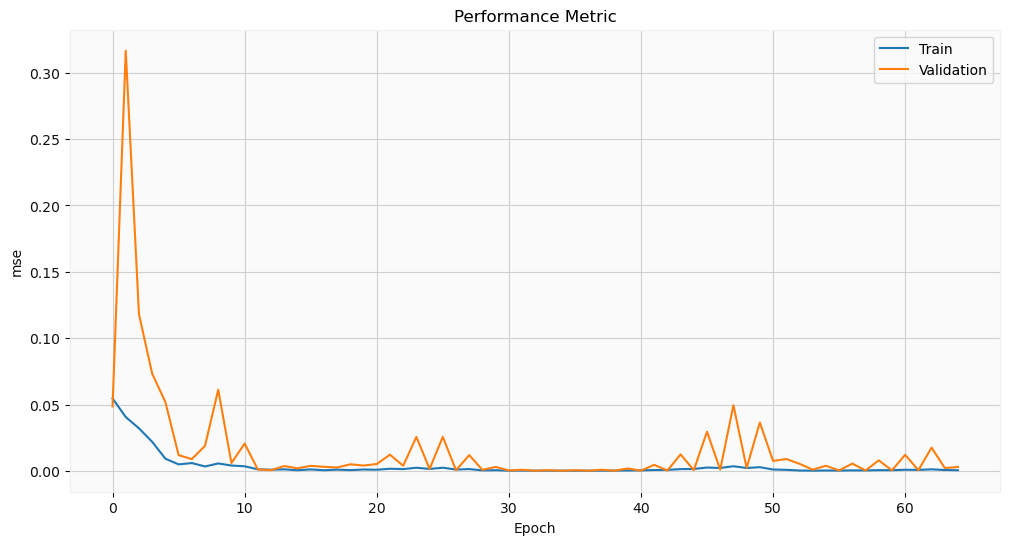

In [14]:
## 4) 모델 훈련
lstm = ForecastLSTM()
lstm.fit_lstm(
    df=df_train,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    **lstm_params,
)

191/191 [==============================] - 0s 2ms/step


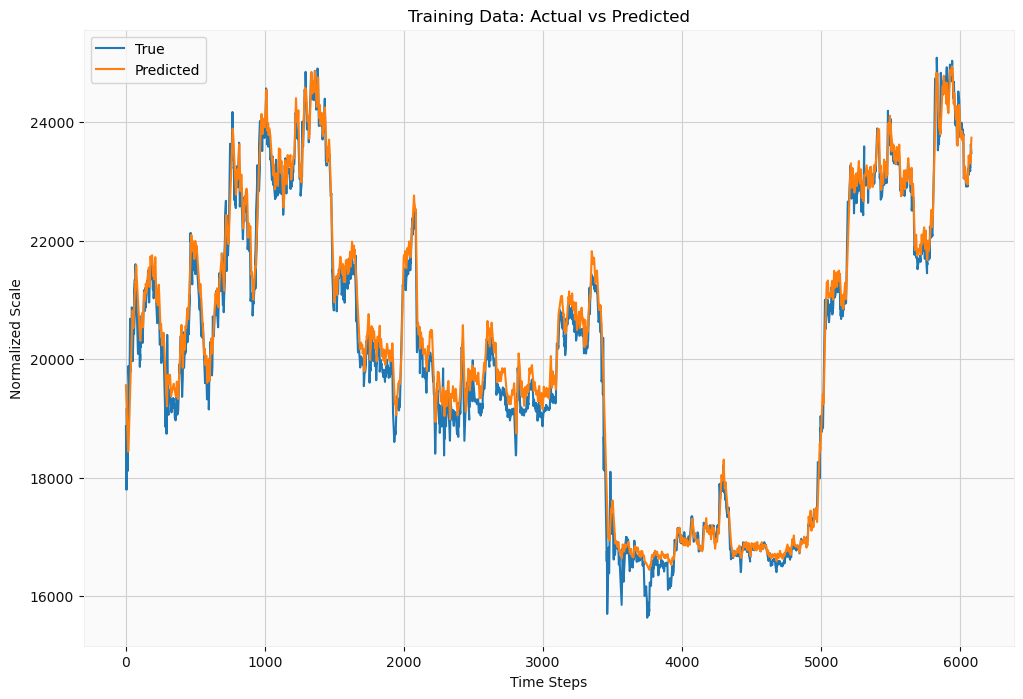

In [16]:
"""
Train Set에 대해 예측을 실시하고, scaler로 부터 역변환하여 normalized data에서 원래의 데이터로의 복원을 수행함.
"""

trainPredict = lstm.model.predict(lstm.X_train)
trainPredict = scaler_close.inverse_transform(np.hstack((np.zeros((trainPredict.shape[0], 4)), trainPredict)))[:, -1]
trainAcutal = scaler_close.inverse_transform(np.hstack((np.zeros((lstm.y_train.shape[0], 4)), lstm.y_train)))[:, -1]

# Plotting the training predictions
plt.figure(figsize=(12,8))
plt.plot(trainAcutal, label='True')
plt.plot(trainPredict, label='Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Scale')
plt.legend()
plt.show()

82/82 [==============================] - 0s 2ms/step


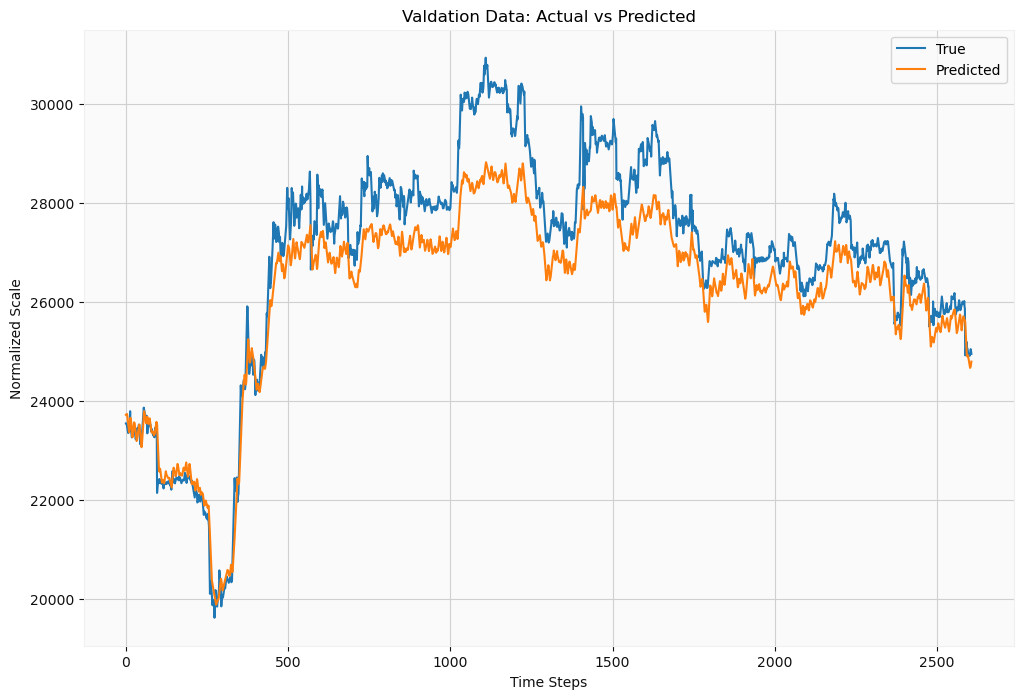

In [17]:
"""
Validation Set에 대해 예측을 실시하고, scaler로 부터 역변환하여 normalized data에서 원래의 데이터로의 복원을 수행함.
"""

valPredict = lstm.model.predict(lstm.X_val)
valPredict = scaler_close.inverse_transform(np.hstack((np.zeros((valPredict.shape[0], 4)), valPredict)))[:, -1]
valAcutal = scaler_close.inverse_transform(np.hstack((np.zeros((lstm.y_val.shape[0], 4)), lstm.y_val)))[:, -1]


# Plotting the training predictions
plt.figure(figsize=(12,8))
plt.plot(valAcutal, label='True')
plt.plot(valPredict, label='Predicted')
plt.title('Valdation Data: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Scale')
plt.legend()
plt.show()

Validation set을 예측하고 시각화한 결과, 실제 가격과 일부 차이가 있지만 경향성에 있어 반영이 정확한 것을 확인할 수 있다.

개선점:
    
- Transformer, ARIMA 등 다른 시계열 예측에 용이한 딥러닝/머신러닝 알고리즘에 대해 연산을 수행하고 best model을 찾으면 더욱 좋을 것 같다.
- 예측된 결과를 통해 24시간, 혹은 1시간 단위로 모델을 새로 생성하고 비교하여 자동으로 매매를 수행하는 스크립트를 짤 예정.